In [1]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 128

## Set up dataset

In [2]:
import torch as ch
from robustness.datasets import CINIC
ds = CINIC('/tmp/cinic')

## Instantiate model

In [23]:
from robustness.model_utils import make_and_restore_model
model, _ = make_and_restore_model(arch='resnet18', dataset=ds,
              resume_path= '/home/ashraf.haddad/mlpr/CINIC_Store_ADV/checkpoint.pt.best') #'/tmp/35daedae-1b39-4941-ad08-8bd6459c1bd8/checkpoint.pt.best')
            
model.eval()
pass

=> loading checkpoint '/home/ashraf.haddad/mlpr/CINIC_Store_ADV/checkpoint.pt.best'
=> loaded checkpoint '/home/ashraf.haddad/mlpr/CINIC_Store_ADV/checkpoint.pt.best' (epoch 56)


## Set up loaders

In [13]:
# device will be 'cuda' if a GPU is available
device = ch.device('cuda' if ch.cuda.is_available() else 'cpu')

_, test_loader = ds.make_loaders(workers=NUM_WORKERS, batch_size=BATCH_SIZE)
_, (im, label) = next(enumerate(test_loader)) 
im,label = im.to(device),label.to(device)


print(im.device, type(im))
print(label.device,type(label))
print(next(model.parameters()).device)

==> Preparing dataset cinic..
cuda:0 <class 'torch.Tensor'>
cuda:0 <class 'torch.Tensor'>
cuda:0


## Generating untargeted adversarial examples

In [22]:
kwargs = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
}
label.size()

torch.Size([128])

In [17]:
#generate adv attack examples
_, im_adv = model(im, label, make_adv=True, **kwargs)

Current loss: 1.2207064628601074: 100%|█████████| 10/10 [00:03<00:00,  3.11it/s]


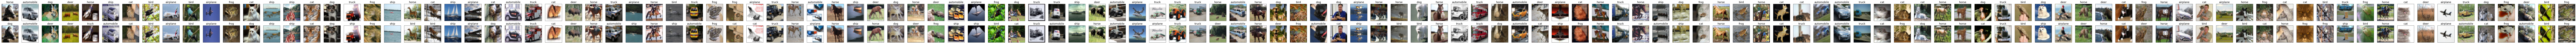

In [21]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples
pred, _ = model(im_adv)
label_pred = ch.argmax(pred, dim=1)

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu()],
         tlist=[[CLASS_DICT['CIFAR'][int(t)] for t in l] for l in [label, label_pred]],
         fontsize=18,
         filename='./adversarial_example_CINIC.png')

## Targeted adversarial examples